In [1]:
import sys
import h5py
import numpy as np
import healpy as hp
import tensorflow as tf
import random as python_random
import nnhealpix.layers
import matplotlib.pyplot as plt
from tensorflow.keras import metrics
import keras
import pandas as pd
import os, shutil
import NN_functions as nuf
from loss_functions import sigma_loss, sigma_f_loss, sigma2_loss,sigma_batch_loss,sigma_norm_loss,sigma_log_loss,mse_tau,mse_sigma

2023-06-26 14:58:51.432783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 14:58:52.734986: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-26 14:58:52.735122: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-26 14:58:52.735141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
#metrics= [sigma_loss,sigma2_loss,sigma_batch_loss,sigma_norm_loss,sigma_log_loss,mse_tau,mse_sigma]
#metrics= [sigma_loss,sigma_batch_loss,mse_tau,mse_sigma,sigma_f_loss]
metrics=[]
#home_dir="/home/amorelli/r_estimate/B_maps_white_noise/results_20_6_23/"
home_dir="/home/amorelli/E_foreground/25b_6_23/"

#r_like=[0.0,0.01,0.03,0.05,0.06] #these are the r_test of the maps on which i test the NN  - case EE white noise
#sigma_exact=[0.00011*2, 0.00152323164284316, 0.00286355246354494,0.00376209725434054,0.0024*2]
#to_load=["test_data_r000_t006_24.npz","test_data_r0010_t006_24.npz","test_data_r0030_t006_24.npz","test_data_r0050_t006_24.npz","test_data_r0060_t006_54.npz"]

#r_like=[0.0,0.001,0.005,0.007,0.01] #these are the r_test of the maps on which i test the NN - case BB white noise
#sigma_exact=[0.000225922*2, 0.000398311, 0.001017338,0.001142098,0.0015324*2] #these are the sigma computed for the 
#to_load=["test_data_r000_t006_77.npz","test_data_r001_t006_78.npz","test_data_r005_t006_79.npz",
 #        "test_data_r007_t006_80.npz","test_data_r0010_t006_81.npz"] #these are the test maps

r_like=[0.01,0.05,0.06,0.07] #case EE foreground d0s0
sigma_exact=[0.000728125734920537*2, 0.0019234656867673, 0.0020744684626319,0.00221000125743489] #these are the sigma computed for the 
to_load=["test_data_r000_t001_7.npz","test_data_r000_t005_8.npz","test_data_r000_t006_9.npz","test_data_r000_t007_10.npz"] #these are the test maps

#r_like=[0.01,0.05,0.06,0.07] #case EE foreground d1s1
#sigma_exact=[0.00074403377826682*2,0.001945305515190439, 0.0020972936206641885 ,0.0022343595567425717] #these are the sigma computed for the 
#to_load=["test_data_r000_t001_7.npz","test_data_r000_t005_8.npz","test_data_r000_t006_9.npz","test_data_r000_t007_10.npz"] #these are the test maps

#r_test using the likelihood approach
#sigma_exact=[0.00073*2, 0.000398311, 0.00207732328746706,0.002335838427700651] tau 0.01,0.06,0.07,0.08
#to_load=["test_data_005_40.npz","test_data_007_40.npz"]

#load_dir='/home/amorelli/r_estimate/B_maps_white_noise/' 
load_dir="/home/amorelli/E_foreground/"

loss_kind="var" #var
#recall var for sigma^2-()^2 and sigma for sigma-()
#what for sigma-()^2?
output_squared=True #if true means that i have sigma^2-()^2 in the loss -> sigma must be squared before computing the variance

loss_training=sigma_batch_loss 
checkpoint_dir=home_dir+"checkpoints"
last=76
to_norm=True
map_norm=True
n_output=2
in_shape=2
nodes_per_layer=[48,256,256]
nside=16
drop=[0.2,0.4,0.3]
n_layers=1
use_drop=[False,True,True]

In [3]:
try:
    hyperparameters=pd.read_csv(home_dir+"output.txt",delim_whitespace=True, index_col=None) #i try to read the 
    #file with the hyperparameters used in the training
except:
    print("no file to read") 
    dataframe={}
    dataframe["no data"]=["-"]
    hyperparameters=pd.DataFrame(dataframe)#if there is no file to read (because i analyse an old model) i create an 
    #empty dataframe
finally:
    None #i use this so that the program continue after the try,except
print(hyperparameters)

       name       loss  noise  p_stopping  p_reduce  f_reduce  \
0  25b_6_23  sigma_log      4          20         5       0.5   

         stop-reduce      lr  batch_size  n_layers nodes_per_layer comments  
0  val_loss-val_loss  0.0001          16         1     48-256-256-           


In [4]:
f_train=np.load(home_dir+"predictions.npz")
norm=f_train["norm"]

In [5]:
files=[]
for name in to_load: 
    files.append(np.load(load_dir+name) )
x_test=[]
y_test=[]
for i,f in enumerate(files):#i take the maps and the corresponding r_test for each input file
    x_test.append(f["x_test"])
    #y=np.zeros(len(x_test[i]))+f["y_test"] #y_test is a single number in the file -> i need to transform it in an array
    #of the same length of x_test
    #y_test.append(y.reshape(y.shape[0],1))
    y_test.append(f["y_test"])

In [6]:
model=nuf.build_network(in_shape,nside,n_layers=1,layer_nodes=nodes_per_layer,
                        num_output=n_output,use_normalization=[False,False,False],
                        use_drop=use_drop,drop=drop,
                        activation_dense="relu",kernel_initializer="glorot_uniform")
model.compile(loss=loss_training, optimizer=tf.optimizers.Adam(),metrics=metrics)

2023-06-26 14:58:59.666306: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-26 14:58:59.666395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (coka.fe.infn.it): /proc/driver/nvidia/version does not exist
2023-06-26 14:58:59.668016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
files=os.listdir(checkpoint_dir)
for f in files:
    splitted = f.split("-")
    if int(splitted[2])==last:
        checkpoint_path=f
        break
print(checkpoint_path)
model.load_weights(checkpoint_dir+'/'+ checkpoint_path)

saved-weights-76-0.12939.hdf5


In [8]:
results=[]
predictions=[]
for x,y in zip(x_test,y_test): #i compute the predictions of the model for each test_set and save them in a dict
    if map_norm:
        for i in range(len(x)):
            for j in range(in_shape):
                t=x[i,:,j]
                x[i,:,j]=nuf.normalize_data(t,t)
    results.append(model.evaluate(x,y,verbose=2) )
    pred=model.predict(x)
    #print(np.mean(pred[:,0]),np.std(pred[:,0]))
    #print(np.mean(norm),np.std(norm))
    if to_norm:
        pred[:,0]=nuf.denormalize_data(pred[:,0],norm)
        if loss_kind=="sigma":
            pred[:,1]*=np.std(norm)
        else:
            pred[:,1]*=np.std(norm)#**2
    print(np.mean(pred[:,0]),np.std(pred[:,0]))
    predictions.append(pred)
npz_dict={}
for i,p in enumerate(predictions):
    npz_dict[f"sigma_{r_like[i]}"]=p[:,1]
np.savez(home_dir+"sigma_out", **npz_dict)

313/313 - 7s - loss: 228.0014 - 7s/epoch - 22ms/step
313/313 [==============================] - 7s 20ms/step
0.0095362095 0.0015597935
313/313 - 6s - loss: 37.7567 - 6s/epoch - 20ms/step
313/313 [==============================] - 6s 20ms/step
0.048306428 0.002277728
313/313 - 6s - loss: 14.6379 - 6s/epoch - 20ms/step
313/313 [==============================] - 6s 20ms/step
0.058448426 0.0026098213
313/313 - 6s - loss: 2.8545 - 6s/epoch - 19ms/step
313/313 [==============================] - 6s 20ms/step
0.068362445 0.002716047


tau_pred=predictions[:,0]
sigma_pred=np.abs(predictions[:,1])#*predictions[:,1]
tau_est=np.mean(tau_pred)
sigma_tau=np.std(tau_pred)**2
#sigma_tau=np.sum((tau_pred-0.06)**2)/10000
sigma_est=np.mean(sigma_pred)
counts_tau, bins_tau = np.histogram(tau_pred)
counts_sigma, bins_sigma = np.histogram(sigma_pred)

In [9]:
if loss_kind=="sigma": #if the output of the NN is directly the std i do some operations and print some values, if
    #it gives the variance i do in a different way
    r_pred=[]
    sigma_pred=[]
    r_est=[]
    sigma_r=[]
    sigma_est=[]
    sigma_sigma=[]
    mae_r=[]
    skeweness_r=[]
    skeweness_sigma=[]
    median_r=[]
    median_sigma=[]
    for i,p in enumerate(predictions): #i compute mean, std, etc for each set of predictions and save them in the corresponding
        #dictionaries (see above)
        r_pred.append(p[:,0])
        sigma_pred.append(p[:,1])
        r_est.append(np.mean(r_pred[i]))
        sigma_r.append(np.std(r_pred[i]))
        sigma_est.append(np.mean(sigma_pred[i]))
        sigma_sigma.append(np.std(sigma_pred[i]))
        mae_r.append(np.sum(np.abs(r_pred[i]-r_est[i]))/len(r_pred[i]))
        skeweness_r.append(np.sum(((r_pred[i]-r_est[i])/sigma_r[i])**3)/len(r_pred[i]))
        skeweness_sigma.append(np.sum(((sigma_pred[i]-sigma_est[i])/sigma_sigma[i])**3)/len(r_pred[i]))
        median_r.append(np.median(r_pred[i]))
        median_sigma.append(np.median(sigma_pred[i]))
    #r_test=np.asarray([int(x*100)/100 for x in r_est])
    #sigma_like=np.empty_like(r_test,dtype=float)
    #for r in r_test:
        #i=r_like.index(r)
        #sigma_like[i]=sigma_exact[i]
    d={}# i create a dictionary that stores the value of the following keywords for each test_set
    d["r_test"]=r_like
    d["r_est"]=r_est
    d["dr"]=np.abs(np.asarray(r_like)-np.asarray(r_est))/r_est
    d["median_r-r_est"]=np.asarray(median_r)-np.asarray(r_est)
    d["mae_r"]=mae_r
    d["skeweness_r"]=skeweness_r
    d["sigma_r"]=sigma_r
    d["sigma_est"]=sigma_est
    d["dsigma"]=np.abs(np.asarray(sigma_r)-np.asarray(sigma_est))/sigma_est
    d["dlike"]=np.abs(np.asarray(sigma_r)-np.asarray(sigma_exact))/sigma_r
    d["sigma_sigma"]=sigma_sigma
    d["median_sigma-sigma_est"]=np.asarray(median_sigma)-np.asarray(sigma_est)
    d["skeweness_sigma"]=skeweness_sigma

    r_data=pd.DataFrame(d)

    #define new DataFrame as original DataFrame with each row repeated 3 times. I do this because i want to join the hyperpar. dataframe
    #with the r_data dataframe and the hyperparam. dataframe only has one row
    hp_new = pd.DataFrame(np.repeat(hyperparameters.values, len(r_est), axis=0))
    #assign column names of original DataFrame to new DataFrame
    hp_new.columns = hyperparameters.columns

    out_df = pd.concat([hp_new, r_data], axis=1) # i join the two dataframes so that i can copy-paste all the info for one model directly
    #in excel

    print(out_df)
    out_df.to_csv(home_dir+'results.txt', index=False, sep=';')

In [10]:
if loss_kind=="sigma": 
    for i in range(len(r_pred)):
        print("on_test_set r =",r_like[i])
        print("r_est:",r_est[i],"  This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.")
        print("sigma_r:",sigma_r[i], " This is the std of the $r_i^{NN}$ array (std of the prediction).")
        print("sigma_r_est:", sigma_est[i], "  This is the average of the $\sigma_{i}$ estimated by the network on the test set.")
        print("\n")

In [11]:
if loss_kind=="sigma":
    fig, ax = plt.subplots(len(r_pred),2, figsize = (12,20))
    for i in range(len(r_pred)): #for each test_set i create an histogram of the r_pred and sigma_pred and print both 
        bin_size=100
        bin_edges= np.histogram_bin_edges(r_pred[i], bins='fd')
        print("n_of_bins:",len(bin_edges))
        counts_tau, bins_tau = np.histogram(r_pred[i], bins=bin_edges) 
        bin_edges= np.histogram_bin_edges(sigma_pred[i], bins='fd')
        counts_sigma, bins_sigma = np.histogram(sigma_pred[i], bins=bin_edges)
        plt.subplot(len(r_pred),2,2*i+1)
        plt.stairs(counts_tau, bins_tau, label="r",  color='k')
        plt.axvline(r_like[i], color="black", linestyle="--", label="r_test")
        #plt.axvline(median_r[i], color="black", linestyle="--", label="r_test")
        plt.axvline(r_est[i], color="red", linestyle="-", label="r_est")
        plt.legend()
        plt.xlabel("$r$")
        plt.ylabel("$counts$")
        plt.ticklabel_format(style='sci',useOffset=True, axis='x', scilimits=[-1, 1])
        plt.subplot(len(r_pred),2,2*i+2)
        plt.stairs(counts_sigma, bins_sigma, label="std estimated by NN",  color='k')
        plt.axvline(sigma_r[i], color="black", linestyle="--", label="std on the r estimated by NN")
        plt.axvline(sigma_est[i], color="red", linestyle="-", label="Average of the std estimated by NN")
        plt.legend()
        plt.ticklabel_format(style='sci',useOffset=True, axis='x', scilimits=[-1, 1])
        plt.xlabel("$\sigma_{r}^{NN}$")
        plt.ylabel("$counts$")
        plt.legend()
        #print(counts_tau, bins_tau)
        #print(np.sort(r_pred[i]))
    #plt.savefig('results_on_test.jpg') #must be in same cell or result image will be blank

In [12]:
if loss_kind!="sigma": #if the output of the NN is directly the std i do some operations and print some values, if
    #it gives the variance i do in a different way
    r_pred=[]
    var_pred=[]
    r_est=[]
    sigma_r=[]
    sigma_est=[]
    sigma_var=[]
    mae_r=[]
    skeweness_r=[]
    skeweness_var=[]
    median_r=[]
    median_var=[]
    for i,p in enumerate(predictions): #i compute mean, std, etc for each set of predictions and save them in the corresponding
        #dictionaries (see above)
        r_pred.append(p[:,0])
        #var_pred.append(p[:,1])
        if output_squared:
            var_pred.append(p[:,1]**2)
        else:
            var_pred.append(p[:,1])
        r_est.append(np.mean(r_pred[i]))
        sigma_r.append(np.std(r_pred[i]))
        sigma_est.append(np.sqrt(np.mean(var_pred[i])))
        sigma_var.append(np.std(var_pred[i]))
        mae_r.append(np.sum(np.abs(r_pred[i]-r_est[i]))/len(r_pred[i]))
        skeweness_r.append(np.sum(((r_pred[i]-r_est[i])/sigma_r[i])**3)/len(r_pred[i]))
        skeweness_var.append(np.sum(((var_pred[i]-sigma_est[i]**2)/sigma_var[i])**3)/len(r_pred[i]))
        median_r.append(np.median(r_pred[i]))
        median_var.append(np.median(var_pred[i]))
    #r_test=np.asarray([int(x*100)/100 for x in r_est])
    #sigma_like=np.empty_like(r_test,dtype=float)
    #for r in r_test:
        #i=r_like.index(r)
        #sigma_like[i]=sigma_exact[i]
    d={}# i create a dictionary that stores the value of the following keywords for each test_set
    d["r_test"]=r_like
    d["r_est"]=r_est
    d["dr"]=np.abs(np.asarray(r_like)-np.asarray(r_est))/r_est
    d["median_r-r_est"]=np.asarray(median_r)-np.asarray(r_est)
    d["mae_r"]=mae_r
    d["skeweness_r"]=skeweness_r
    d["sigma_r"]=sigma_r
    d["sigma_est"]=sigma_est
    d["dsigma"]=np.abs(np.asarray(sigma_r)-np.asarray(sigma_est))/sigma_est
    d["dlike"]=np.abs(np.asarray(sigma_r)-np.asarray(sigma_exact))/sigma_r
    d["sigma_var"]=sigma_var
    d["median_var-var_est"]=np.asarray(median_var)-np.asarray(sigma_est)**2
    d["skeweness_var"]=skeweness_var

    r_data=pd.DataFrame(d)

    #define new DataFrame as original DataFrame with each row repeated 3 times. I do this because i want to join the hyperpar. dataframe
    #with the r_data dataframe and the hyperparam. dataframe only has one row
    hp_new = pd.DataFrame(np.repeat(hyperparameters.values, len(r_est), axis=0))
    #assign column names of original DataFrame to new DataFrame
    hp_new.columns = hyperparameters.columns

    out_df = pd.concat([hp_new, r_data], axis=1) # i join the two dataframes so that i can copy-paste all the info for one model directly
    #in excel

    print(out_df)
    out_df.to_csv(home_dir+'results.txt', index=False, sep=';')

       name       loss noise p_stopping p_reduce f_reduce        stop-reduce  \
0  25b_6_23  sigma_log     4         20        5      0.5  val_loss-val_loss   
1  25b_6_23  sigma_log     4         20        5      0.5  val_loss-val_loss   
2  25b_6_23  sigma_log     4         20        5      0.5  val_loss-val_loss   
3  25b_6_23  sigma_log     4         20        5      0.5  val_loss-val_loss   

       lr batch_size n_layers  ... median_r-r_est     mae_r  skeweness_r  \
0  0.0001         16        1  ...      -0.000015  0.001243     0.073805   
1  0.0001         16        1  ...      -0.000034  0.001818     0.094963   
2  0.0001         16        1  ...       0.000063  0.002082    -0.111015   
3  0.0001         16        1  ...       0.000044  0.002182    -0.056382   

    sigma_r  sigma_est    dsigma     dlike  sigma_var  median_var-var_est  \
0  0.001560   0.008962  0.825959  0.066382   0.000002        6.635673e-09   
1  0.002278   0.005883  0.612846  0.155533   0.000002        7.4

In [13]:
if loss_kind!="sigma": 
    for i in range(len(r_pred)):
        print("on_test_set r =",r_like[i])
        print("r_est:",r_est[i],"  This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.")
        print("sigma_r:",sigma_r[i], " This is the std of the $r_i^{NN}$ array (std of the prediction).")
        print("sigma_r_est:", sigma_est[i], "  This is the square root of the average of the $\sigma_{i}$ estimated by the network on the test set. In this case the sigma_i is indeed an estimate of the variance")
        print("\n")

on_test_set r = 0.01
r_est: 0.0095362095   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.0015597935  This is the std of the $r_i^{NN}$ array (std of the prediction).
sigma_r_est: 0.008962206   This is the square root of the average of the $\sigma_{i}$ estimated by the network on the test set. In this case the sigma_i is indeed an estimate of the variance


on_test_set r = 0.05
r_est: 0.048306428   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.002277728  This is the std of the $r_i^{NN}$ array (std of the prediction).
sigma_r_est: 0.005883263   This is the square root of the average of the $\sigma_{i}$ estimated by the network on the test set. In this case the sigma_i is indeed an estimate of the variance


on_test_set r = 0.06
r_est: 0.058448426   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.0026098213  This is the std of the $r_i^{NN}$ array (st

n_of_bins: 64
n_of_bins: 70
n_of_bins: 64
n_of_bins: 65


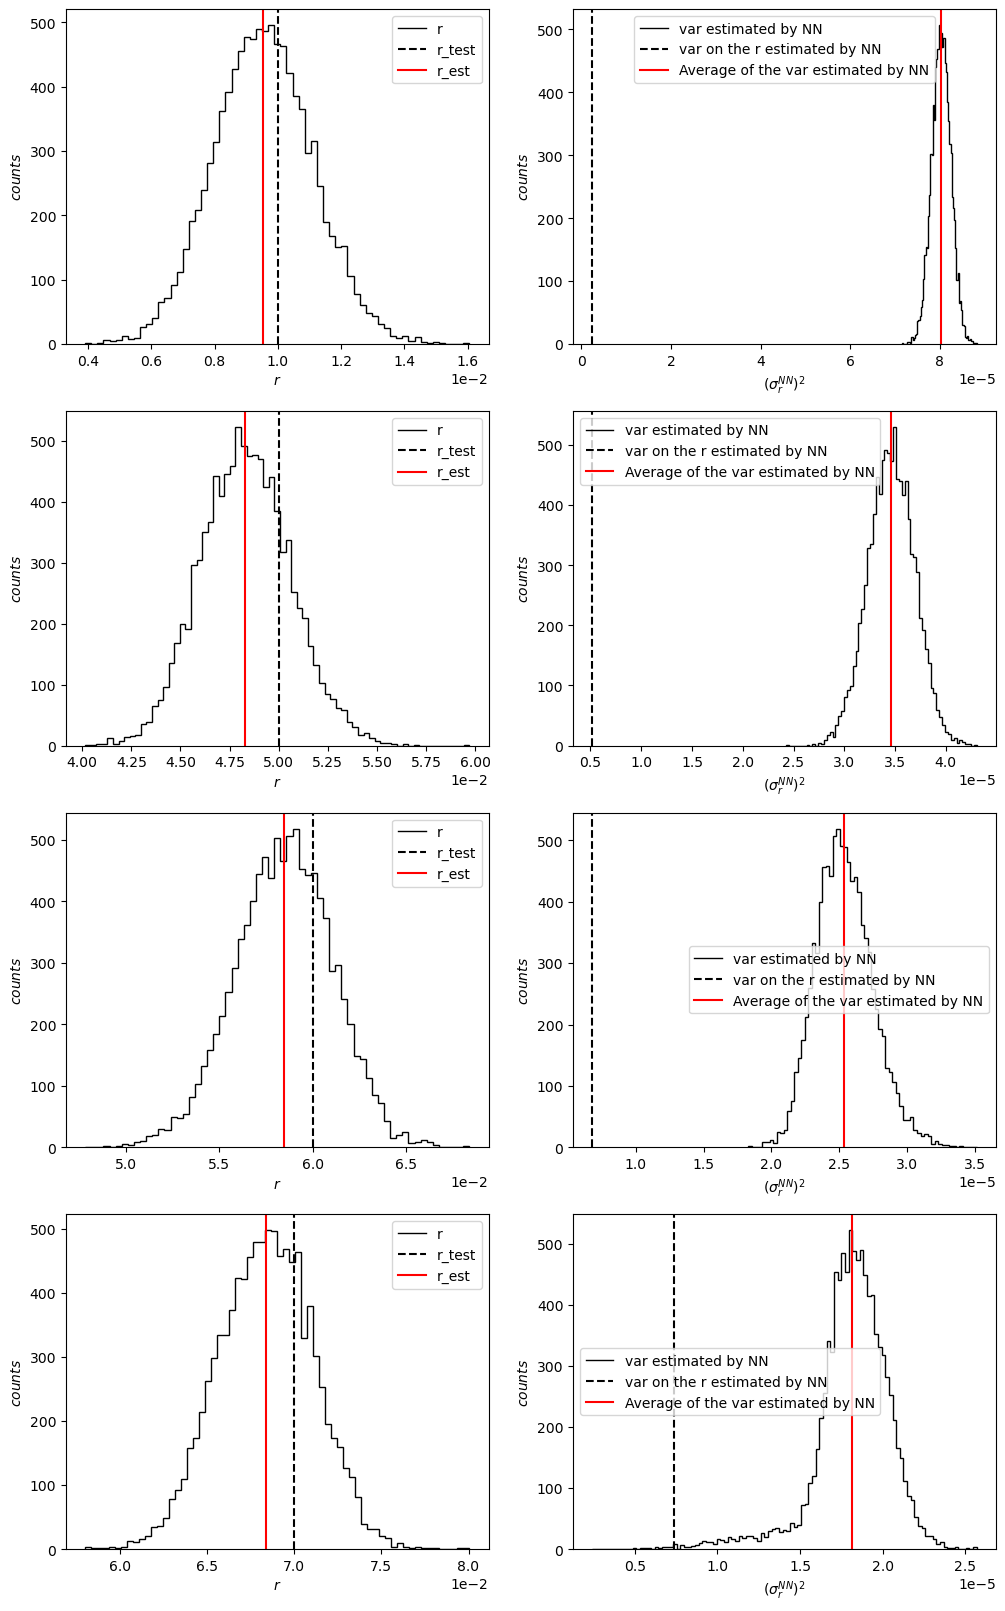

In [14]:
if loss_kind!="sigma":
    fig, ax = plt.subplots(len(r_pred),2, figsize = (12,20))
    for i in range(len(r_pred)): #for each test_set i create an histogram of the r_pred and sigma_pred and print both 
        bin_size=100
        bin_edges= np.histogram_bin_edges(r_pred[i], bins='fd')
        print("n_of_bins:",len(bin_edges))
        counts_tau, bins_tau = np.histogram(r_pred[i], bins=bin_edges) 
        bin_edges= np.histogram_bin_edges(var_pred[i], bins='fd')
        counts_sigma, bins_sigma = np.histogram(var_pred[i], bins=bin_edges)
        plt.subplot(len(r_pred),2,2*i+1)
        plt.stairs(counts_tau, bins_tau, label="r",  color='k')
        plt.axvline(r_like[i], color="black", linestyle="--", label="r_test")
        #plt.axvline(median_r[i], color="black", linestyle="--", label="r_test")
        plt.axvline(r_est[i], color="red", linestyle="-", label="r_est")
        plt.legend()
        plt.xlabel("$r$")
        plt.ylabel("$counts$")
        plt.ticklabel_format(style='sci',useOffset=True, axis='x', scilimits=[-1, 1])
        plt.subplot(len(r_pred),2,2*i+2)
        plt.stairs(counts_sigma, bins_sigma, label="var estimated by NN",  color='k')
        plt.axvline(sigma_r[i]**2, color="black", linestyle="--", label="var on the r estimated by NN")
        plt.axvline(sigma_est[i]**2, color="red", linestyle="-", label="Average of the var estimated by NN")
        plt.legend()
        plt.ticklabel_format(style='sci',useOffset=True, axis='x', scilimits=[-1, 1])
        plt.xlabel("$(\sigma_{r}^{NN})^2$")
        plt.ylabel("$counts$")
        plt.legend()
        #print(counts_tau, bins_tau)
        #print(np.sort(r_pred[i]))
    #plt.savefig('results_on_test.jpg') #must be in same cell or result image will be blank